In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string 
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras import losses

In [2]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1', url, untar = True, cache_dir = '.',  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [3]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [5]:
pos_dir = os.path.join(train_dir, 'pos')
os.listdir(pos_dir)

['0_9.txt',
 '10000_8.txt',
 '10001_10.txt',
 '10002_7.txt',
 '10003_8.txt',
 '10004_8.txt',
 '10005_7.txt',
 '10006_7.txt',
 '10007_7.txt',
 '10008_7.txt',
 '10009_9.txt',
 '1000_8.txt',
 '10010_7.txt',
 '10011_9.txt',
 '10012_8.txt',
 '10013_7.txt',
 '10014_8.txt',
 '10015_8.txt',
 '10016_8.txt',
 '10017_9.txt',
 '10018_8.txt',
 '10019_8.txt',
 '1001_8.txt',
 '10020_8.txt',
 '10021_8.txt',
 '10022_7.txt',
 '10023_9.txt',
 '10024_9.txt',
 '10025_9.txt',
 '10026_7.txt',
 '10027_7.txt',
 '10028_10.txt',
 '10029_10.txt',
 '1002_7.txt',
 '10030_10.txt',
 '10031_10.txt',
 '10032_10.txt',
 '10033_10.txt',
 '10034_8.txt',
 '10035_9.txt',
 '10036_8.txt',
 '10037_9.txt',
 '10038_10.txt',
 '10039_10.txt',
 '1003_10.txt',
 '10040_10.txt',
 '10041_10.txt',
 '10042_10.txt',
 '10043_10.txt',
 '10044_9.txt',
 '10045_10.txt',
 '10046_9.txt',
 '10047_10.txt',
 '10048_10.txt',
 '10049_8.txt',
 '1004_7.txt',
 '10050_10.txt',
 '10051_10.txt',
 '10052_10.txt',
 '10053_8.txt',
 '10054_10.txt',
 '10055_7.tx

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())


Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train', batch_size = batch_size,
                                                          validation_split = 0.2,
                                                          subset = 'training',
                                                          seed = seed)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(2):
    for i in range(3):
        print('Review:', text_batch.numpy()[i])
        print('Label:', label_batch.numpy()[i])

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label: 0
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get in

In [10]:
print('Label 0 correspond to', raw_train_ds.class_names[0])
print('Label 1 correspond to', raw_train_ds.class_names[1])


Label 0 correspond to neg
Label 1 correspond to pos


In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train',
                                                       batch_size = batch_size,
                                                       validation_split = 0.2,
                                                       subset = 'validation',
                                                       seed = seed)


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/test',
                                                        batch_size = batch_size)


Found 25000 files belonging to 2 classes.


In [13]:
def custom_standartization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                   '[%s]' % re.escape(string.punctuation),
                                   '')

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(standardize = custom_standartization,
                                          max_tokens = max_features,
                                          output_mode = 'int',
                                          output_sequence_length = sequence_length)

In [15]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [16]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [17]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  85,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2421,
           1,   51,   22,   25,  404,  251,   12,  308,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [18]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  lovely
 313 --->  american
Vocabulary size: 10000


In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [22]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [23]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 7s 11ms/step - loss: 0.6665 - binary_accuracy: 0.6904 - val_loss: 0.6198 - val_binary_accuracy: 0.7690
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5541 - binary_accuracy: 0.7965 - val_loss: 0.5035 - val_binary_accuracy: 0.8210
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4500 - binary_accuracy: 0.8428 - val_loss: 0.4242 - val_binary_accuracy: 0.8442
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3825 - binary_accuracy: 0.8643 - val_loss: 0.3768 - val_binary_accuracy: 0.8584
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3380 - binary_accuracy: 0.8781 - val_loss: 0.3474 - val_binary_accuracy: 0.8662
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3070 - binary_accuracy: 0.8878 - val_loss: 0.3281 - val_binary_accuracy: 0.8692
Epoch 7/10
625/625 [==============================] - 1s 2ms/st

In [26]:
loss, accuracy = model.evaluate(test_ds)

print('Loss', loss)
print('Accuracy', accuracy)

782/782 [==============================] - 0s 584us/step - loss: 0.3110 - binary_accuracy: 0.8726
Loss 0.3109595477581024
Accuracy 0.8726000189781189


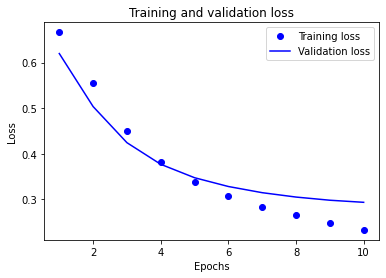

In [28]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

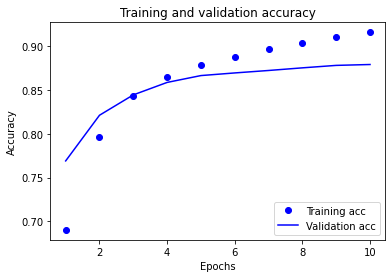

In [29]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()